In [1]:
import pandas as pd 
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
import matplotlib.pyplot as plt

In [24]:
from statsmodels.tsa.stattools import adfuller, kpss
import warnings
warnings.filterwarnings('ignore')

In [58]:
landsat = pd.read_csv('data/landsat_features_training.csv')

In [15]:
df = pd.read_csv('data/final_glorich_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46556 entries, 0 to 46555
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STAT_ID          46556 non-null  int64  
 1   Latitude         46556 non-null  float64
 2   Longitude        46556 non-null  float64
 3   geometry         46556 non-null  object 
 4   sc               46556 non-null  float64
 5   ss               46556 non-null  float64
 6   su               46556 non-null  float64
 7   mt               46556 non-null  float64
 8   va               46556 non-null  float64
 9   vb               46556 non-null  float64
 10  vi               46556 non-null  float64
 11  pa               46556 non-null  float64
 12  pb               46556 non-null  float64
 13  pi               46556 non-null  float64
 14  GLC_Artificial   46556 non-null  float64
 15  GLC_Managed      46556 non-null  float64
 16  GLC_Water        46556 non-null  float64
 17  GLC_Aquatic_

In [16]:
df['date'] = pd.to_datetime(df['date'])


In [17]:
df = df.sort_values('date')

In [ ]:
def stationarity_test(series, name):
    series = series.dropna()  # critical — these columns have missing values
    
    print(f"\n{'='*50}")
    print(f"Variable: {name}  (n={len(series)})")
    print(f"{'='*50}")
    
    # --- ADF Test ---
    adf_result = adfuller(series, autolag='AIC')
    print(f"\n[ADF Test]")
    print(f"  Statistic : {adf_result[0]:.4f}")
    print(f"  p-value   : {adf_result[1]:.4f}")
    print(f"  Result    : {'/ Stationary' if adf_result[1] < 0.05 else 'Non-stationary'}")
    
    # --- KPSS Test ---
    kpss_result = kpss(series, regression='c', nlags='auto')
    print(f"\n[KPSS Test]")
    print(f"  Statistic : {kpss_result[0]:.4f}")
    print(f"  p-value   : {kpss_result[1]:.4f}")
    print(f"  Result    : {'/ Stationary' if kpss_result[1] > 0.05 else 'Non-stationary'}")

In [22]:
df.columns

Index(['STAT_ID', 'Latitude', 'Longitude', 'geometry', 'sc', 'ss', 'su', 'mt',
       'va', 'vb', 'vi', 'pa', 'pb', 'pi', 'GLC_Artificial', 'GLC_Managed',
       'GLC_Water', 'GLC_Aquatic_Veg', 'GLC_PERC_COV', 'Popdens_00', 'Soil_pH',
       'SOC', 'Soil_wetness', 'pH', 'SpecCond25C', 'Alkalinity', 'Cl', 'SO4',
       'DIP', 'date'],
      dtype='object')

In [23]:
# ── CONFIG ────────────────────────────────────────────────────────────────────
TARGET_COLS = ['pH', 'SpecCond25C', 'Alkalinity', 'Cl', 'SO4', 'DIP']
MIN_OBS     = 20       # absolute minimum to run any test
SHORT_THRESHOLD = 50   # per-station obs < this → "short"
LONG_THRESHOLD  = 100  # per-station obs > this → "long"

df = df.sort_values(['STAT_ID', 'date'])

def check_observations(df, col):
    # Count observations per station (use a non-null column as reference)
    station_obs = df.groupby('STAT_ID')[col].count()  # swap col if pH is sparse
    
    n_stations       = len(station_obs)
    median_obs       = station_obs.median()
    mean_obs         = station_obs.mean()
    pct_short        = (station_obs < SHORT_THRESHOLD).mean() * 100
    pct_long         = (station_obs > LONG_THRESHOLD).mean() * 100
    
    print("=" * 55)
    print(f"         COLUMN PROFILE: {col}")
    print("=" * 55)
    print(f"  Total stations         : {n_stations}")
    
    print(f"Column")
    print(f"  Median obs/station     : {median_obs:.0f}")
    print(f"  Mean obs/station       : {mean_obs:.0f}")
    print(f"  % stations with <{SHORT_THRESHOLD} obs : {pct_short:.1f}%")
    print(f"  % stations with >{LONG_THRESHOLD} obs : {pct_long:.1f}%")
    print("=" * 55)
    
cols = ['Soil_pH',
       'SOC', 'Soil_wetness', 'pH', 'SpecCond25C', 'Alkalinity', 'Cl', 'SO4',
       'DIP']
for col in cols: 
    check_observations(df, col)

         COLUMN PROFILE: Soil_pH
  Total stations         : 1207
Column
  Median obs/station     : 38
  Mean obs/station       : 39
  % stations with <50 obs : 64.8%
  % stations with >100 obs : 0.0%
         COLUMN PROFILE: SOC
  Total stations         : 1207
Column
  Median obs/station     : 38
  Mean obs/station       : 39
  % stations with <50 obs : 64.8%
  % stations with >100 obs : 0.0%
         COLUMN PROFILE: Soil_wetness
  Total stations         : 1207
Column
  Median obs/station     : 38
  Mean obs/station       : 39
  % stations with <50 obs : 64.8%
  % stations with >100 obs : 0.0%
         COLUMN PROFILE: pH
  Total stations         : 1207
Column
  Median obs/station     : 35
  Mean obs/station       : 36
  % stations with <50 obs : 67.9%
  % stations with >100 obs : 0.0%
         COLUMN PROFILE: SpecCond25C
  Total stations         : 1207
Column
  Median obs/station     : 30
  Mean obs/station       : 34
  % stations with <50 obs : 68.8%
  % stations with >100 obs : 0.0%


## IPS test 


In [42]:
def run_panel_ips(df):
    from scipy import stats

    print("\n[Panel IPS Test — manual implementation]")
    records = []

    for col in TARGET_COLS:
        t_stats = []

        for station, grp in df.groupby('STAT_ID'):
            series = grp.sort_values('date')[col].dropna()
            if len(series) < MIN_OBS:
                continue
            try:
                t_stats.append(adfuller(series, autolag='AIC')[0])
            except:
                continue

        if len(t_stats) < 2:
            print(f"  {col}: not enough stations — skipped")
            continue

        n     = len(t_stats)
        Z_ips = (np.sqrt(n) * (np.mean(t_stats) - (-1.504))) / np.sqrt(1.002)
        pval  = stats.norm.cdf(Z_ips)

        verdict = 'Stationary' if pval < 0.05 else 'Non-stationary'
        print(f"  {col:<15} Z={Z_ips:7.3f}  p={pval:.4f}  n_stations={n}  → {verdict}")
        records.append({'variable': col, 'Z_ips': round(Z_ips, 4),
                        'p_value': round(pval, 4), 'n_stations': n,
                        'verdict': verdict})

    return pd.DataFrame(records)

In [43]:
results = run_panel_ips(df)


[Panel IPS Test — manual implementation]
  pH              Z=-97.072  p=0.0000  n_stations=788  → Stationary
  SpecCond25C     Z=-63.830  p=0.0000  n_stations=744  → Stationary
  Alkalinity      Z=-64.576  p=0.0000  n_stations=574  → Stationary
  Cl              Z=-67.882  p=0.0000  n_stations=643  → Stationary
  SO4             Z=-75.349  p=0.0000  n_stations=677  → Stationary
  DIP             Z=-697.072  p=0.0000  n_stations=716  → Stationary


Based on Panel-IPS test, all values are stationary. Next, we are doing the diagnostic test to check whether all stations are stationary per variable. 

In [47]:
def run_per_station_diagnostic(df):
    records = []

    for station, grp in df.groupby('STAT_ID'):
        grp = grp.sort_values('date')
        
        for col in TARGET_COLS:
            series = grp[col].dropna()
            if len(series) < MIN_OBS:
                continue
            try:
                adf_p  = adfuller(series, autolag='AIC')[1]
                kpss_p = kpss(series, regression='c', nlags='auto')[1]

                if   adf_p < 0.05 and kpss_p > 0.05: verdict = 'Stationary'
                elif adf_p > 0.05 and kpss_p < 0.05: verdict = 'Non-stationary'
                elif adf_p < 0.05 and kpss_p < 0.05: verdict = 'Trend-stationary'
                else:                                  verdict = 'Diff-stationary'

                records.append({
                    'STAT_ID': station,
                    'variable'  : col,
                    'n'         : len(series),
                    'adf_p'     : round(adf_p, 4),
                    'kpss_p'    : round(kpss_p, 4),
                    'verdict'   : verdict
                })
            except:
                continue

    results = pd.DataFrame(records)

    # ── 1. Overall summary: % stationary per variable
    print("\n[% of stations stationary per variable]")
    summary = results.groupby('variable')['verdict'].value_counts(normalize=True).mul(100).round(1)
    print(summary.to_string())

    # ── 2. Non-stationary stations per variable
    print("\n[Non-stationary stations per variable]")
    non_stat = results[results['verdict'] != 'Stationary']
    for col in TARGET_COLS:
        subset = non_stat[non_stat['variable'] == col][['STAT_ID', 'n', 'adf_p', 'kpss_p', 'verdict']]
        if len(subset) == 0:
            print(f"\n  {col}: all stations stationary ✅")
        else:
            print(f"\n  {col} — {len(subset)} non-stationary stations:")
            print(subset.sort_values('adf_p', ascending=False).to_string(index=False))

    # ── 3. Problem stations: flagged across multiple variables
    print("\n[Stations non-stationary in multiple variables]")
    problem_stations = (non_stat.groupby('STAT_ID')['variable']
                                .apply(list)
                                .reset_index()
                                .rename(columns={'variable': 'problem_variables'}))
    problem_stations['n_problem_vars'] = problem_stations['problem_variables'].apply(len)
    problem_stations = problem_stations.sort_values('n_problem_vars', ascending=False)
    print(problem_stations[problem_stations['n_problem_vars'] > 1].to_string(index=False))

    return results

results = run_per_station_diagnostic(df)


[% of stations stationary per variable]
variable     verdict         
Alkalinity   Stationary          69.5
             Diff-stationary     17.6
             Trend-stationary     8.9
             Non-stationary       4.0
Cl           Stationary          59.6
             Diff-stationary     17.4
             Trend-stationary    14.2
             Non-stationary       8.9
DIP          Stationary          71.5
             Diff-stationary     14.2
             Trend-stationary    10.1
             Non-stationary       4.2
SO4          Stationary          60.9
             Diff-stationary     16.0
             Trend-stationary    15.2
             Non-stationary       8.0
SpecCond25C  Stationary          62.4
             Diff-stationary     19.5
             Trend-stationary    10.5
             Non-stationary       7.7
pH           Stationary          63.8
             Trend-stationary    15.0
             Diff-stationary     13.7
             Non-stationary       7.5

[Non-stationary 

In [55]:
def plot_stationarity(df, station):
    grp = df[df['STAT_ID'] == station].sort_values('date')
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    fig.suptitle(f'Station {station} — Non-stationary in ALL variables', fontsize=14)
    
    for ax, col in zip(axes.flatten(), TARGET_COLS):
        grp[col].plot(ax=ax, title=col)
        ax.set_xlabel('')
    
    plt.tight_layout()
    plt.savefig(f'station_{station}_diagnostic.png')
    plt.show()
    

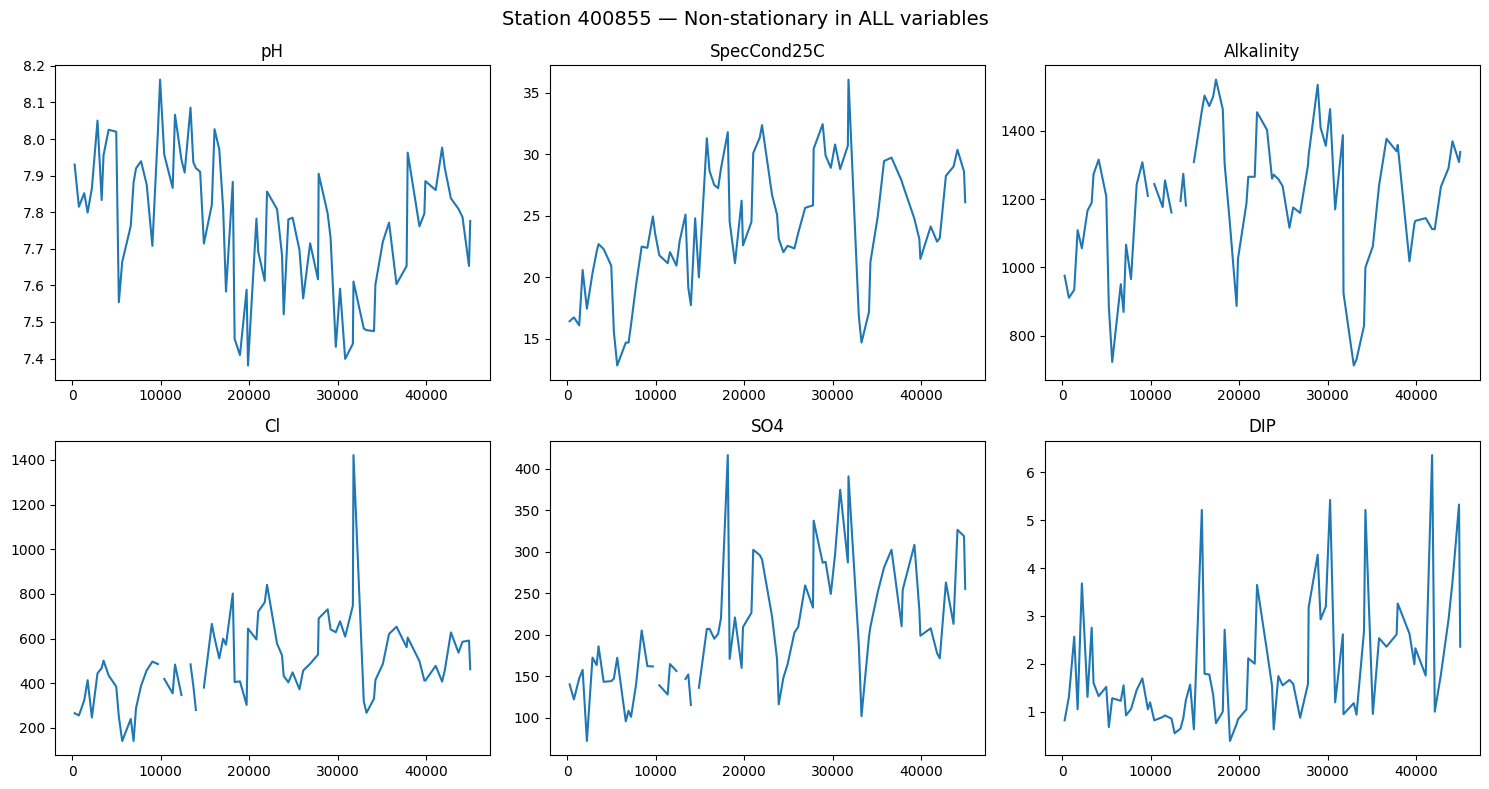

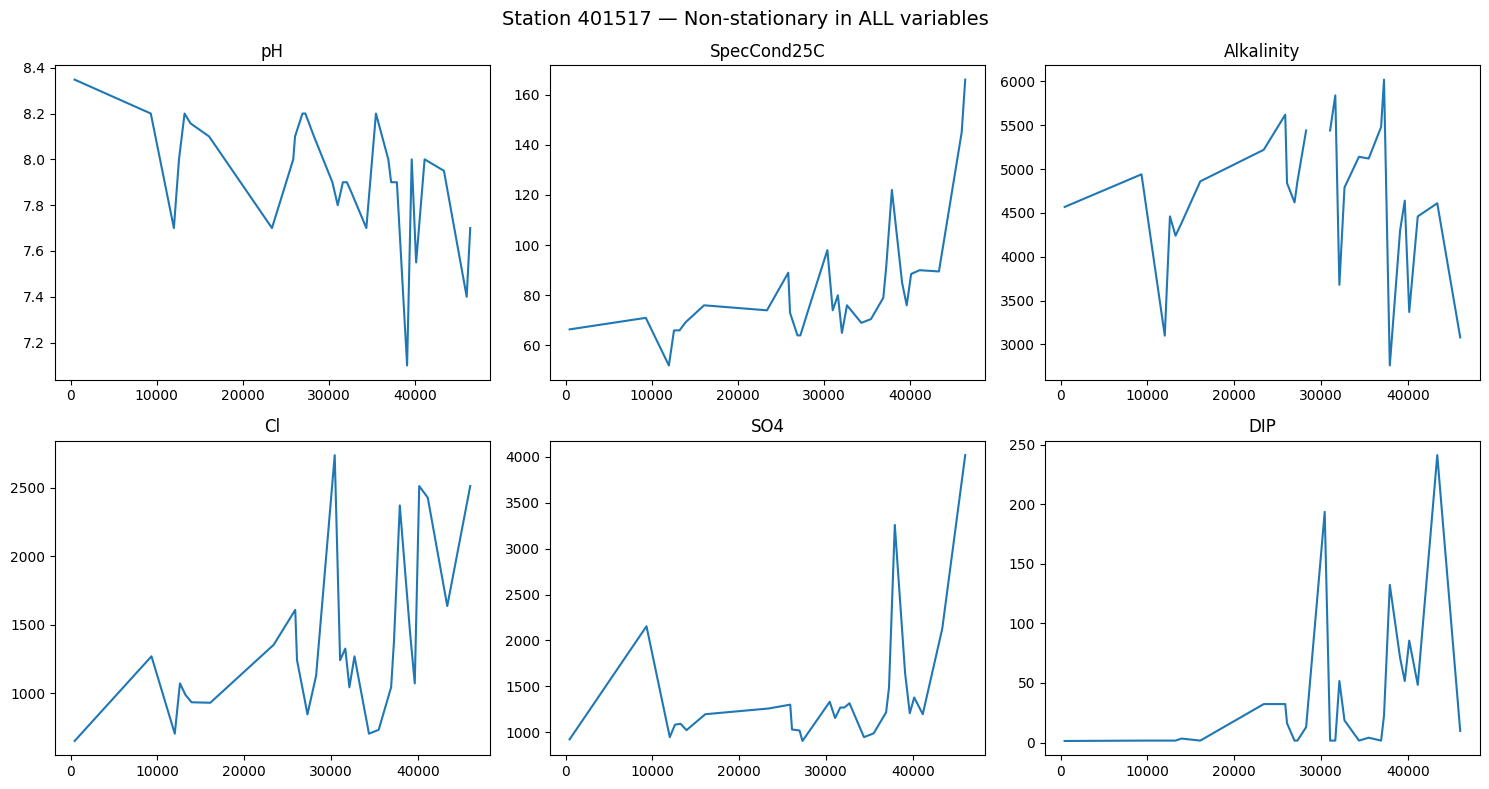

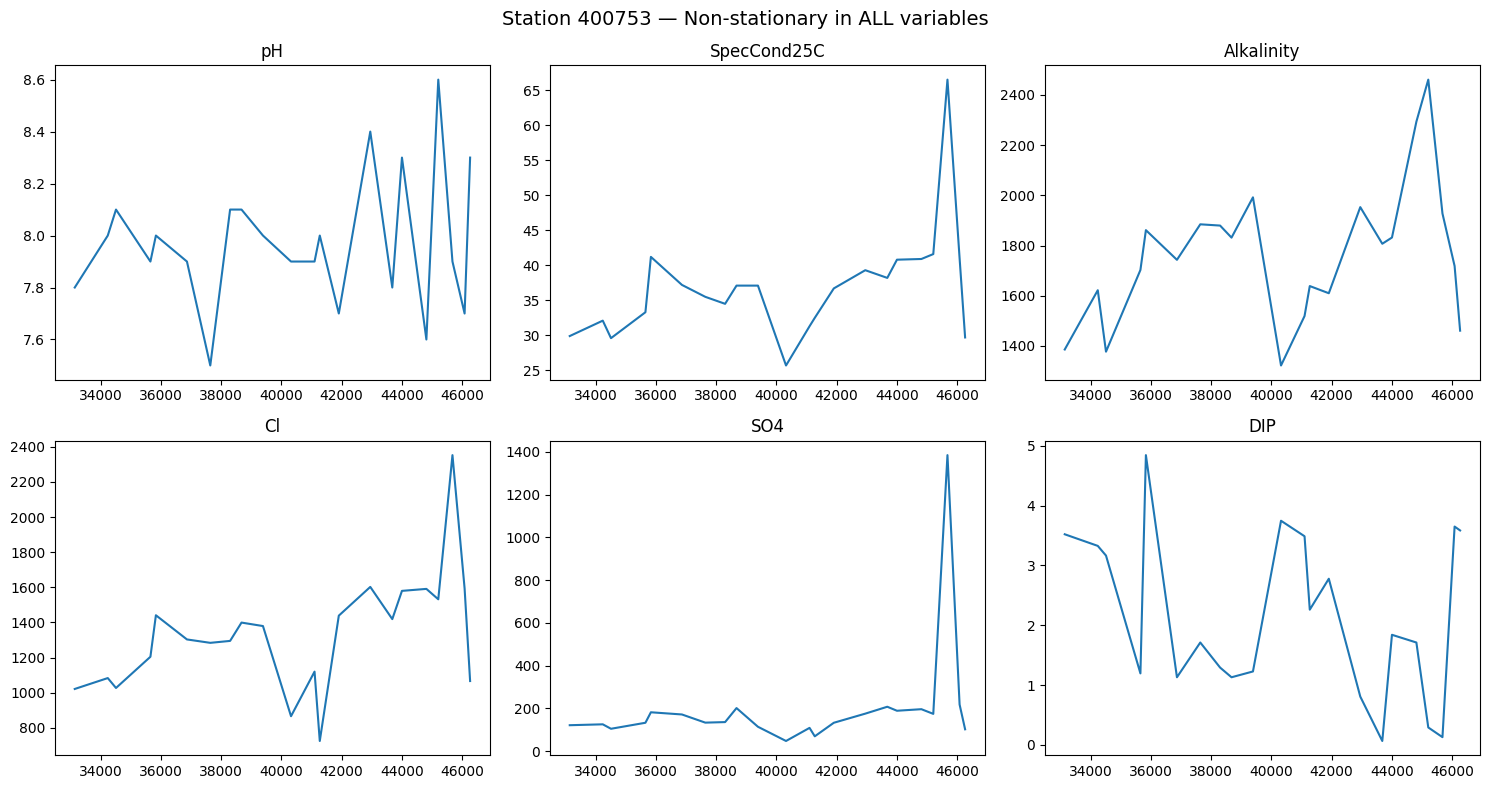

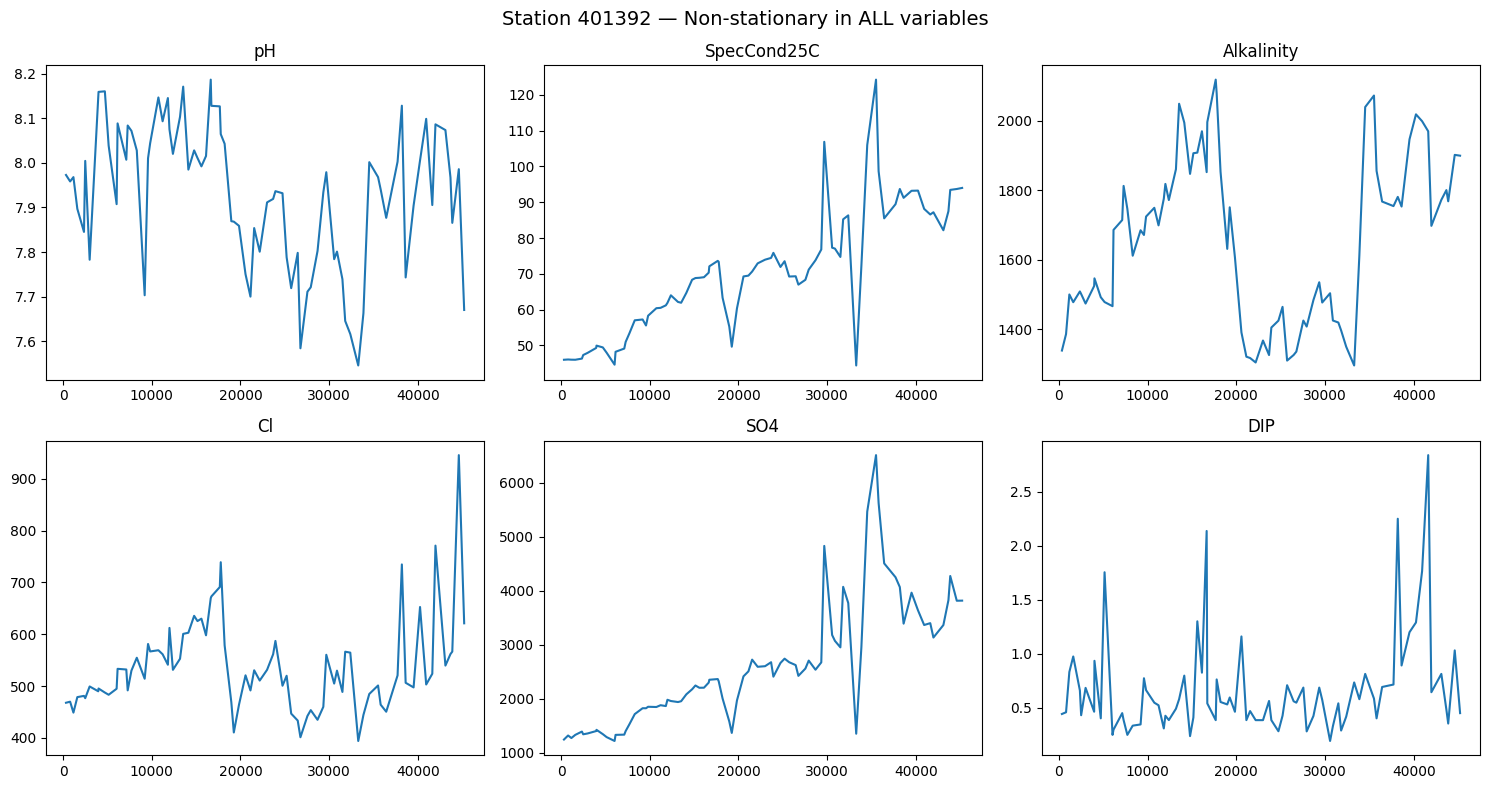

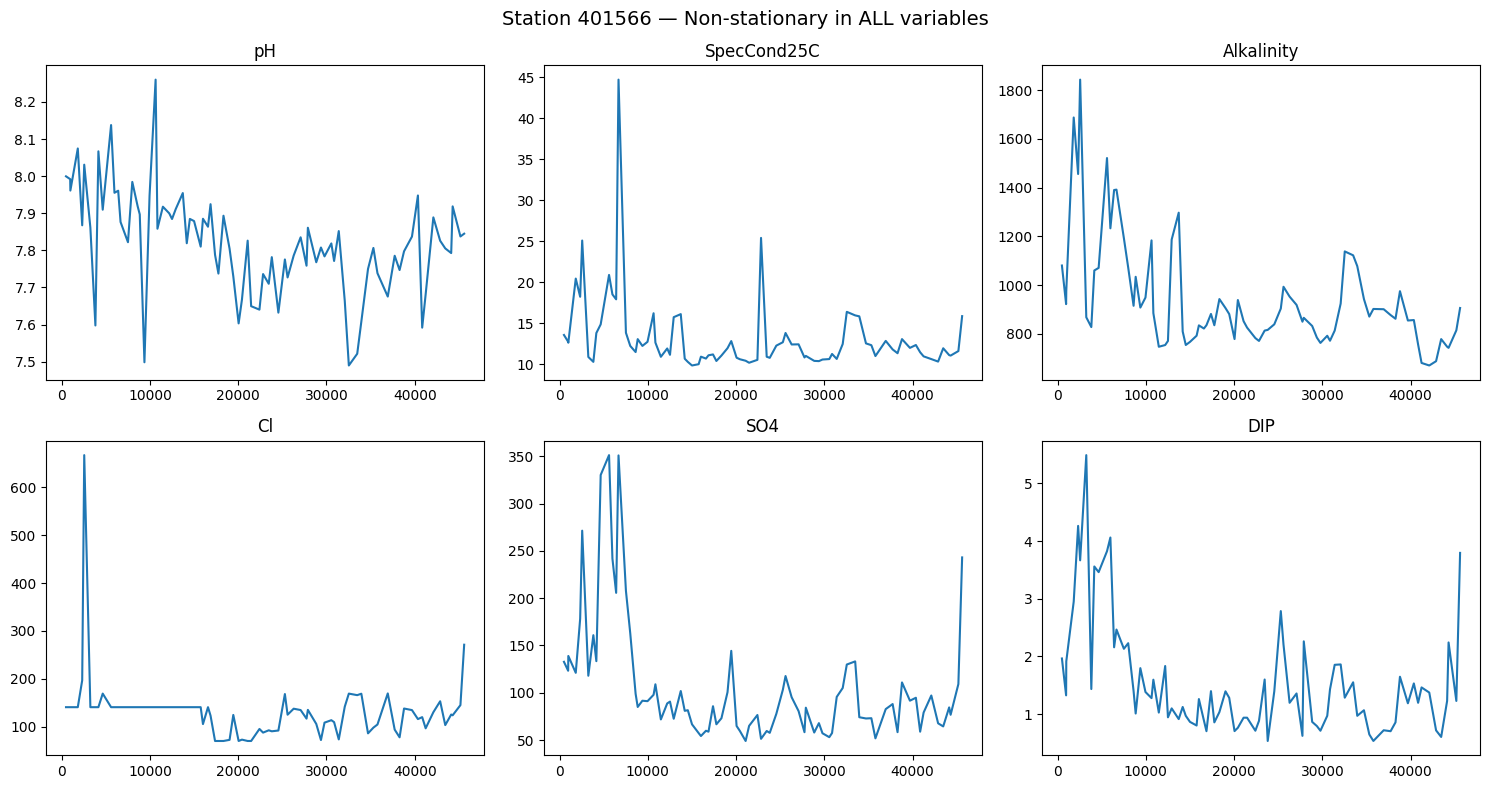

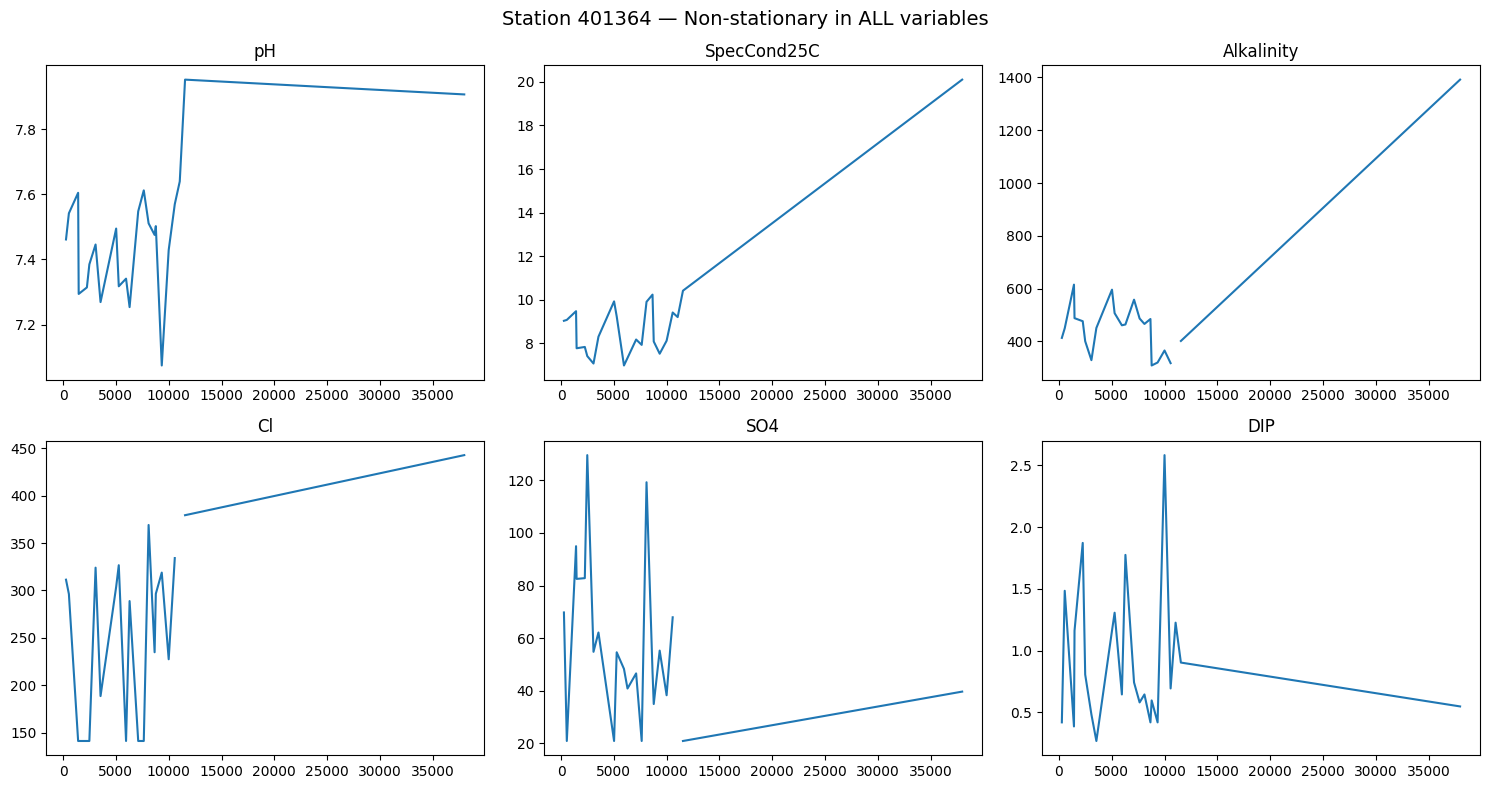

In [56]:
# critical stations 
stations = [400855, 401517, 400753, 401392, 401566, 401364]

for s in stations:
    plot_stationarity(df, s)

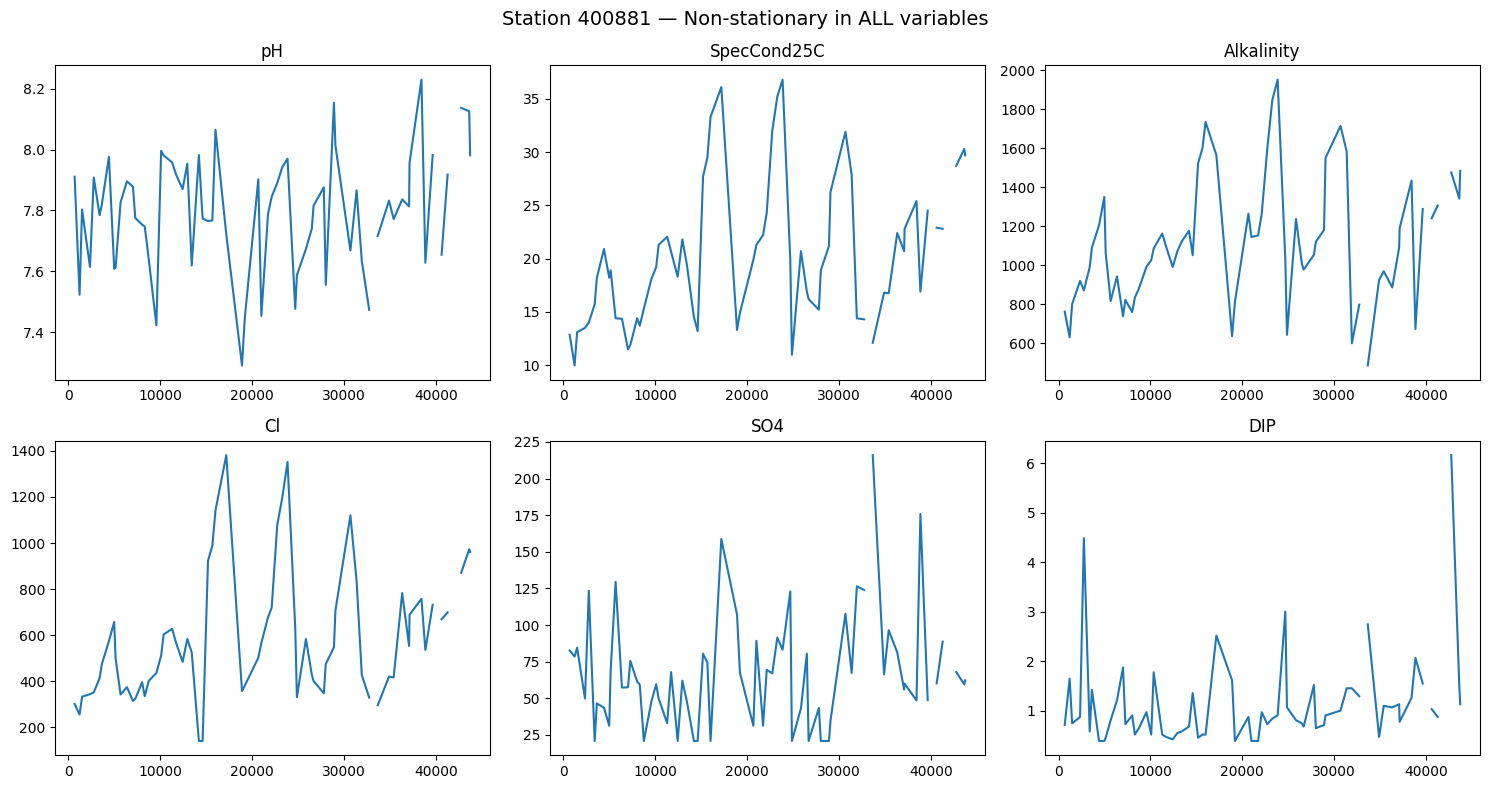

In [57]:
plot_stationarity(df,400881)

In [59]:
landsat.head()

,Latitude,Longitude,Sample Date,nir,green,swir16,swir22,NDMI,MNDWI
0,-28.760833,17.730278,02-01-2011,11190.0,11426.0,7687.5,7645.0,0.185538,0.195595
1,-26.861111,28.884722,03-01-2011,17658.5,9550.0,13746.5,10574.0,0.124566,-0.180134
2,-26.450000,28.085833,03-01-2011,15210.0,10720.0,17974.0,14201.0,-0.083293,-0.252805
3,-27.671111,27.236944,03-01-2011,14887.0,10943.0,13522.0,11403.0,0.048048,-0.105416
4,-27.356667,27.286389,03-01-2011,16828.5,9502.5,12665.5,9643.0,0.141147,-0.142683


In [61]:
results.head(30)

,STAT_ID,variable,n,adf_p,kpss_p,verdict
0,400020,pH,30,0.0083,0.0791,Stationary
1,400020,SpecCond25C,30,0.0001,0.0979,Stationary
2,400020,DIP,29,0.0012,0.0177,Trend-stationary
3,400021,pH,31,0.0135,0.1000,Stationary
4,400021,SpecCond25C,31,0.0000,0.1000,Stationary
5,400021,DIP,30,0.5176,0.0405,Non-stationary
6,400022,pH,26,0.0058,0.1000,Stationary
7,400022,SpecCond25C,26,0.0109,0.1000,Stationary
8,400022,DIP,26,0.1107,0.0754,Diff-stationary
9,400024,pH,29,0.0000,0.1000,Stationary


In [70]:
from scipy import stats
# ── Generate future dates to impute (biweekly to match original sampling)
future_dates = pd.date_range(start='2011-01-01', end='2015-12-31', freq='SMS')

# ── Reliability score per verdict
reliability_map = {
    'Stationary'      : 1.0,   # fully reliable
    'Trend-stationary': 0.7,   # reliable but assumes trend continues
    'Diff-stationary' : 0.4,   # last value forward — weakens over time
    'Non-stationary'  : 0.1   # least reliable
}
imputed_records = []

for station, grp in df.groupby('STAT_ID'):
    grp = grp.sort_values('date')
    
    for col in TARGET_COLS:
        series = grp[col].dropna()
        
        if len(series) < 10:
            continue
        
        # ── Look up verdict from stationarity results
        match = results[
            (results['STAT_ID'] == station) & 
            (results['variable'] == col)
        ]
        
        # If station was stationary, verdict is not in results — default to 'Stationary'
        verdict = match['verdict'].values[0] if len(match) > 0 else 'Stationary'
        
        # ── Impute based on verdict
        for future_date in future_dates:
            
            if verdict == 'Stationary':
                # Use historical mean — series is stable
                imputed_val = series.mean()
            
            elif verdict == 'Diff-stationary':
                # Random walk — best guess is last observed value
                imputed_val = series.iloc[-1]
                years_ahead  = future_date.year - 2011
                reliability  = max(0.1, 0.4 - (years_ahead * 0.07))
            
            elif verdict == 'Trend-stationary':
                # Extend the linear trend forward
                x = np.arange(len(series))
                slope, intercept, _, _, _ = stats.linregress(x, series.values)
                
                # How many steps beyond the last observation?
                last_date  = series.index[-1] if hasattr(series.index, 'month') else grp['date'].iloc[-1]
                steps_ahead = (future_date.year - last_date.year) * 24  # biweekly steps
                future_x   = len(series) + steps_ahead
                imputed_val = slope * future_x + intercept
            
            elif verdict == 'Non-stationary':
                # Least reliable — use median as robust estimate
                imputed_val = series.median()
            
            imputed_records.append({
                'STAT_ID'  : station,
                'date'     : future_date,
                'variable' : col,
                'value'    : imputed_val,
                'method'   : verdict,
                'n_train'  : len(series),
                'reliability': reliability_map.get(verdict, 0.5)
            })

imputed_df = pd.DataFrame(imputed_records)

# ── Pivot to wide format so each variable is a column
imputed_wide = imputed_df.pivot_table(
    index   = ['STAT_ID', 'date'],
    columns = 'variable',
    values  = 'value'
).reset_index()

reliability_wide = imputed_df.pivot_table(
    index  = ['STAT_ID', 'date'],
    columns= 'variable',
    values = 'reliability'
).reset_index()

reliability_wide.columns = [
    f'{col}_reliability' if col not in ['STAT_ID', 'date'] else col
    for col in reliability_wide.columns
]

imputed_final = imputed_wide.merge(reliability_wide, on=['STAT_ID', 'date'])

print(imputed_final.columns.tolist())

['STAT_ID', 'date', 'Alkalinity', 'Cl', 'DIP', 'SO4', 'SpecCond25C', 'pH', 'Alkalinity_reliability', 'Cl_reliability', 'DIP_reliability', 'SO4_reliability', 'SpecCond25C_reliability', 'pH_reliability']


In [72]:
imputed_final.describe()


,STAT_ID,date,Alkalinity,Cl,DIP,SO4,SpecCond25C,pH,Alkalinity_reliability,Cl_reliability,DIP_reliability,SO4_reliability,SpecCond25C_reliability,pH_reliability
count,110640.000000,110640,77400.000000,86880.000000,100200.000000,91320.000000,103800.000000,109560.000000,77400.000000,86880.000000,100200.000000,91320.000000,103800.000000,109560.000000
mean,400858.199566,2013-06-23 06:24:00.000000256,2361.798164,2562.546007,13.123632,997.281393,70.889967,7.701598,0.850233,0.798619,0.868503,0.810381,0.813064,0.832092
min,400020.000000,2011-01-01 00:00:00,-15404.120932,-145034.778906,-553.444841,-70135.700335,-1193.556954,2.161737,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000
25%,400528.000000,2012-03-27 18:00:00,808.745385,308.751816,0.951268,75.247942,17.800000,7.420382,0.700000,0.700000,1.000000,0.700000,0.700000,0.700000
50%,400848.500000,2013-06-23 00:00:00,1898.960000,789.845000,1.737647,278.072461,44.093750,7.785185,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,401298.000000,2014-09-19 00:00:00,3296.672000,1803.008889,7.247129,945.656000,74.552500,8.048750,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,401573.000000,2015-12-15 00:00:00,36560.565674,199674.807342,750.692526,63034.347956,4591.660144,18.464538,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
std,441.072611,NaN,2451.491139,11088.621807,52.003271,4462.614539,167.131063,0.832899,0.264467,0.300367,0.252086,0.291195,0.294777,0.279944


In [73]:
imputed_final.to_csv("data/imputed_conditions_11-15.csv", index=False)
results.to_csv("data/stationarity_results.csv", index=False)